## Demo Notebook

### Importing stuff and setting color palette

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from mpi4py import MPI
from ipywidgets import interact
import os
import time
from nemesispy.common.constants import ATM, G, AU, R_SUN, R_EAR_E, M_EAR, K_B, R_JUP_E, M_JUP
from nemesispy.common.info_mol_id import mol_id
from nemesispy.radtran.forward_model import ForwardModel
from nemesispy.radtran.calc_mmw import calc_mmw
from nemesispy.models.gas_profiles import gen_vmr_clr, gen_vmr
from scipy import special
sns.set_style('ticks')
colors = ['#817', '#a35', '#c66', '#e94', '#ed0', '#9d5', '#4d8', '#2cb', '#0bc', '#09c', '#36b', '#639']
sns.set_palette(sns.color_palette(colors))
sns.color_palette(colors)

[(0.5333333333333333, 0.06666666666666667, 0.4666666666666667),
 (0.6666666666666666, 0.2, 0.3333333333333333),
 (0.8, 0.4, 0.4),
 (0.9333333333333333, 0.6, 0.26666666666666666),
 (0.9333333333333333, 0.8666666666666667, 0.0),
 (0.6, 0.8666666666666667, 0.3333333333333333),
 (0.26666666666666666, 0.8666666666666667, 0.5333333333333333),
 (0.13333333333333333, 0.8, 0.7333333333333333),
 (0.0, 0.7333333333333333, 0.8),
 (0.0, 0.6, 0.8),
 (0.2, 0.4, 0.7333333333333333),
 (0.4, 0.2, 0.6)]

### Select which gases to use, select ktables and CIA file

In [2]:
# Spectrally active gases to include
gas_names_active = ['H2O', 'CO2', 'CO', 'NH3', 'CH4', 'SO2', 'HCN', 'C2H2']
# Spectrally inactive gases to include
# N2 not included in this notebook
gas_names_inactive = ['H2', 'He']#['N2']

gas_id = [mol_id[gas] for gas in gas_names_active] + [mol_id[gas] for gas in gas_names_inactive]
gas_id = np.array(gas_id)
iso_id = np.zeros_like(gas_id)

lowres_file_paths = [f'{gas}_flatline.kta' for gas in gas_names_active]
# $nemesispy_dir is top level nemesispy directory folder's path
__location__ = os.environ['nemesispy_dir']
ktable_path = os.path.join(__location__, "nemesispy/data/ktables")
for ipath,path in enumerate(lowres_file_paths):
    lowres_file_paths[ipath] = os.path.join(ktable_path,path)
cia_folder_path = os.path.join(__location__ , "nemesispy/data/cia")
cia_file_path = os.path.join(cia_folder_path,'exocia_hitran12_200-3800K.tab')
gas_id

array([ 1,  2,  5, 11,  6,  9, 23, 26, 39, 40])

### Create a Forward Model Object and add the ktables and cia file to it

In [3]:
FM = ForwardModel()
FM.set_opacity_data(kta_file_paths=lowres_file_paths, cia_file_path=cia_file_path)

### Set number of pressure levels, layers and P array

In [4]:
n_plevels = 50
NLAYER = n_plevels
P = np.logspace(1, -7, n_plevels) * ATM # in Pa
print(f'Bottom of atmosphere 3 pressures:{P[:3]/ATM} Atm')
print(f'Top of atmosphere 3 pressures:{P[-3:]/ATM} Atm')

Bottom of atmosphere 3 pressures:[10.          6.86648845  4.71486636] Atm
Top of atmosphere 3 pressures:[2.12095089e-07 1.45634848e-07 1.00000000e-07] Atm


### Set system parameters

In [5]:
# L98-59 d
R_star = 0.303 * R_SUN # m M3V star, 80 day rotation period, >0.8 Gyr
M_plt = 1.94 * M_EAR # kg
R_plt = 1.521 * R_EAR_E # m
SMA = 0.0486 * AU # m
T_star = 3415.0 # K
g_plt = G * M_plt / R_plt**2
T_eq = T_star * (R_star/(2*SMA))**0.5
T_int = 200.0 # randomly set

### Set gas abundances and create vmr array

In [6]:
gases = np.array([-12.0, -4.0, -12.0, -12.0, -12.0, -12.0, -12.0, -12.0])
vmr = gen_vmr(NLAYER, gases)
vmr[0]

array([1.0000000e-12, 1.0000000e-04, 1.0000000e-12, 1.0000000e-12,
       1.0000000e-12, 1.0000000e-12, 1.0000000e-12, 1.0000000e-12,
       8.5461453e-01, 1.4528547e-01])

### Input all system parameters and vmr array into 

In [7]:
FM.set_planet_model(M_plt=M_plt, R_plt=R_plt, R_star=R_star, gas_id_list=gas_id,
                iso_id_list=iso_id, NLAYER=NLAYER)

### Defining TP profile function (will be put in a module later)

In [8]:
def TP_Line(k,g1,g2,alpha,beta):
    kappa = 10**k
    gamma1 = 10**g1
    gamma2 = 10**g2
    T_irr = beta * T_eq
    tau = kappa * P / g_plt # optical depth, assuming g_plt is constant
    xi1 = (2./3.) * ( 1 + (1/gamma1)*(1+(0.5*gamma1*tau-1)*np.exp(-gamma1*tau))\
            + gamma1 * (1-0.5*tau**2) * special.expn(2, gamma1*tau) )
    xi2 = (2./3.) * ( 1 + (1/gamma2)*(1+(0.5*gamma2*tau-1)*np.exp(-gamma2*tau))\
            + gamma2 * (1-0.5*tau**2) * special.expn(2, gamma2*tau) )
    flux1 = (0.75 * T_int**4) * ((2./3.)+tau)
    flux2 = (0.75 * T_irr**4) * (1-alpha) * xi1
    flux3 = (0.75 * T_irr**4) * alpha * xi2
    TP = (flux1+flux2+flux3)**0.25
    return TP

### Create a TP Profile and plot it

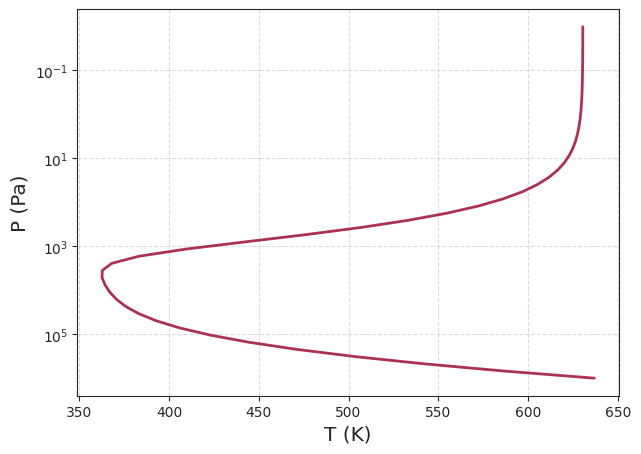

In [9]:
k, g1, g2, alpha, beta = -3.0, 1.0, 1.0, 0.5, 1.0
T = TP_Line(k, g1, g2, alpha, beta)
fig, ax = plt.subplots()
plt.plot(T, P, linewidth=2, color=colors[1])
ax.set_xlabel('T (K)', size='x-large')
ax.set_ylabel('P (Pa)', size='x-large')
plt.gca().invert_yaxis()
plt.tight_layout()
ax.set_yscale('log')
ax.grid(True, linestyle='--', alpha=0.7)
plt.show()

### Set cloud parameters

In [10]:
Ptop = 1.0e-4 * ATM # Pa
# power = -1.0
tau_c_param = 1e30

### Generate transmission spectrum by adding in the TP profile and cloud parameters to forward model object
#### Should take about 20s

In [16]:
model = FM.calc_transm_spectrum(P, T, vmr, path_angle=90.0, Ptop=Ptop, power=None, solspec=[])

### Plot the spectrum with G395H wavelength range highlighted

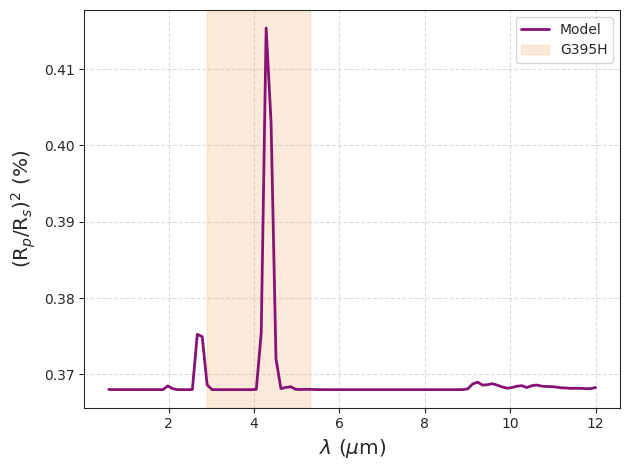

In [17]:
fig, ax = plt.subplots()
wave_grid = FM.wave_grid
plt.plot(wave_grid, model, color=colors[0], linewidth=2, label='Model')
plt.axvspan(2.9, 5.3, alpha=0.2, color=colors[3], label='G395H')
plt.xlabel('$\lambda$ ($\mu$m)', size='x-large')
plt.ylabel('(R$_p$/R$_s$)$^2$ (%)', size='x-large')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend()
plt.show()

(50, 100) (50, 100) (100,)


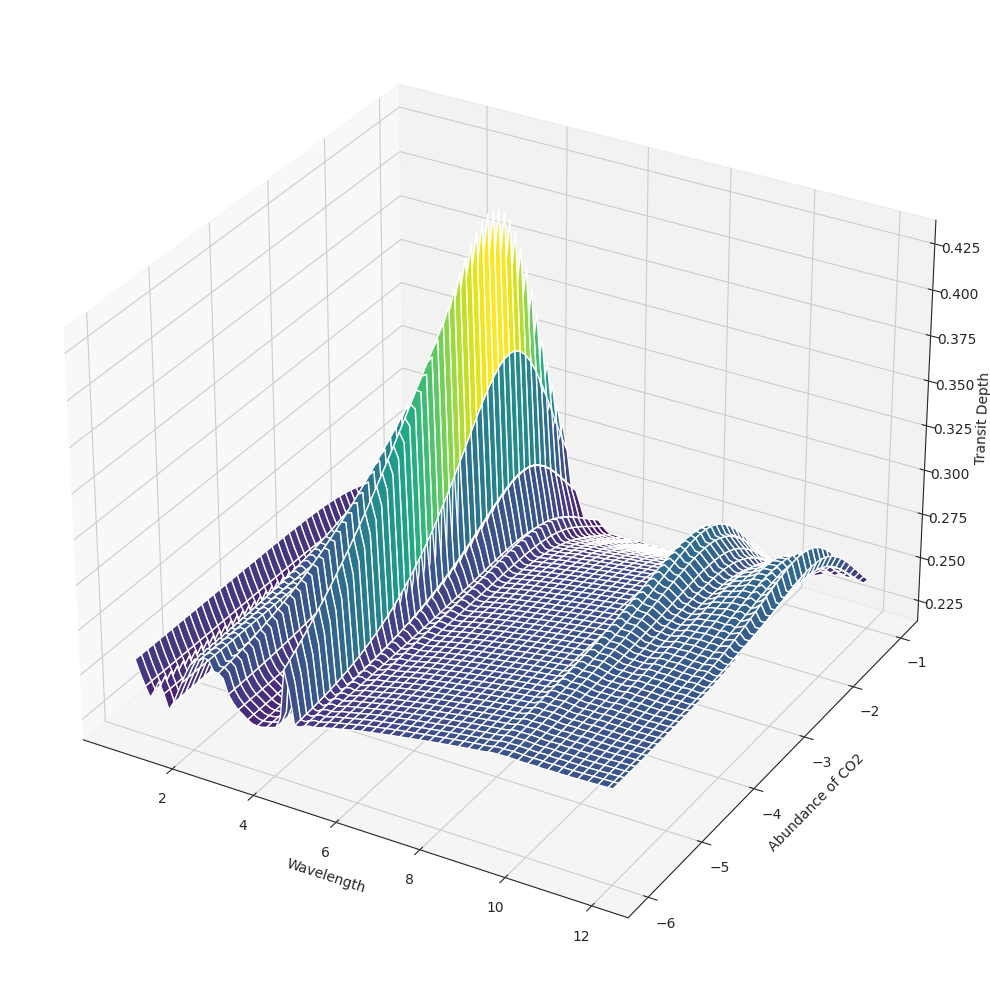

In [14]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
gas_abun = np.linspace(-1, -6, 50)
# Create a meshgrid for wvl and P
models = np.zeros((len(gas_abun), len(wave_grid)))
for i in range(len(gas_abun)):
    gases[1] = gas_abun[i]
    vmr = gen_vmr(NLAYER, gases)
    model = FM.calc_transm_spectrum(P, T, vmr, path_angle=90.0, Ptop=None, power=None, solspec=[])
    models[i] = model
ww, gg = np.meshgrid(wave_grid, gas_abun)
print(ww.shape, gg.shape, model.shape)
# Plot the surface
ax.plot_surface(ww, gg, models, cmap='viridis')

# Set labels for the axes
ax.set_xlabel('Wavelength')
ax.set_ylabel('Abundance of CO2')
ax.set_zlabel('Transit Depth')
plt.tight_layout()
# Show the plot
plt.show()


### Interactive TP Plotter

In [13]:
def T_plotter(k,g1,g2,alpha,beta):
    T = TP_Line(k, g1, g2, alpha, beta)
    fig, ax = plt.subplots()
    plt.plot(T, P)
    ax.set_xlabel('T (K)', size='x-large')
    ax.set_ylabel('P (Pa)', size='x-large')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    ax.set_yscale('log')
    ax.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# k, g1, g2, alpha, beta = -3.0, 1.0, 1.0, 0.5, 1.0
interact(T_plotter, k=(-4,4,1),
         g1=(-4,4,1), g2=(-4,4,1),
         alpha=(0,1,0.1), beta=(0,2,0.2));

interactive(children=(IntSlider(value=0, description='k', max=4, min=-4), IntSlider(value=0, description='g1',…

In [14]:
### Set TP to something for the next bit
k, g1, g2, alpha, beta = -3.0, 1.0, 1.0, 0.5, 1.0
T = TP_Line(k, g1, g2, alpha, beta)

### Interactive Spectrum Plotter

In [15]:
def spec_plotter(h2o, co2, co, nh3, ch4, so2, hcn, c2h2 ,Ptop, power):
    gases = np.array([h2o, co2, co, nh3, ch4, so2, hcn, c2h2])
    vmr = gen_vmr(NLAYER,gases)
    Ptop = 10**Ptop * ATM
    model = FM.calc_transm_spectrum(P,T,vmr,path_angle=90.0,Ptop=Ptop, power=power,solspec=[])
    fig, ax = plt.subplots()
    plt.plot(wave_grid, model, linewidth=2, color=colors[0], label='Model')
    plt.axvspan(2.9, 5.3, alpha=0.2, color=colors[3], label='G395H')
    plt.xlabel('$\lambda$ ($\mu$m)', size='x-large')
    plt.ylabel('(R$_p$/R$_s$)$^2$ (%)', size='x-large')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.legend()
    plt.show()

interact(spec_plotter, h2o=(-10,-1,1),
            co2=(-10,-1,1), co=(-10,-1,1),
            nh3=(-10,-1,1), ch4=(-10,-1,1),
            so2=(-10,-1,1), hcn=(-10,-1,1),
            c2h2=(-10,-1,1), Ptop=(-5,2,1),
            power=(-4,5,1));

interactive(children=(IntSlider(value=-6, description='h2o', max=-1, min=-10), IntSlider(value=-6, description…

### The whole spectrum generation process at once (timed)

In [20]:
# number of times to compute spectrum (just to check computation speed)
ntime = 10
t0 = time.time()
for i in range(10):
    if i == 1:
        t_mid = time.time()
    FM = ForwardModel()
    FM.set_opacity_data(kta_file_paths=lowres_file_paths, cia_file_path=cia_file_path)
    vmr = gen_vmr(NLAYER, gases)
    FM.set_planet_model(M_plt=M_plt, R_plt=R_plt, R_star=R_star, gas_id_list=gas_id,
                    iso_id_list=iso_id, NLAYER=NLAYER)
    model = FM.calc_transm_spectrum(P,T,vmr,path_angle=90.0,Ptop=Ptop, power=power,solspec=[])
t1 = time.time()
print(f"Time taken: {t1-t0:.2f} s for {ntime} iterations")
print(f"Time taken excluding first iteration: {t1-t_mid:.2f} s for {ntime-1} iterations")

Time taken: 10.36 s for 10 iterations
Time taken excluding first iteration: 8.65 s for 9 iterations
